<a href="https://colab.research.google.com/github/alexc6h6/Sequences-Model-RNN/blob/master/DJI_predicton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Activation, BatchNormalization, Dropout, Lambda, LayerNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
print(tf.__version__)


2.2.0


In [2]:
#!pip install --upgrade tensorflow


In [3]:
drive.mount('/content/drive/')

!ls '/content/drive/My Drive/DJI.csv'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
'/content/drive/My Drive/DJI.csv'


In [4]:
data = pd.read_csv('/content/drive/My Drive/DJI.csv')

data['Up'] = np.abs(data['Close']-data['High'])
data['Down'] = np.abs(data['Close'] - data['Low'])


In [5]:
data = data.iloc[-2000:]

In [6]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Up,Down
6919,2012-07-06,12889.400391,12889.400391,12702.990234,12772.469727,12772.469727,96760000,116.930664,69.479493
6920,2012-07-09,12772.019531,12772.019531,12686.570313,12736.290039,12736.290039,100150000,35.729492,49.719726
6921,2012-07-10,12733.870117,12830.290039,12606.910156,12653.120117,12653.120117,114760000,177.169922,46.209961
6922,2012-07-11,12653.040039,12661.969727,12534.330078,12604.530273,12604.530273,128420000,57.439454,70.200195
6923,2012-07-12,12602.709961,12630.639648,12492.250000,12573.269531,12573.269531,142760000,57.370117,81.019531


In [7]:
data.shape

(2000, 9)

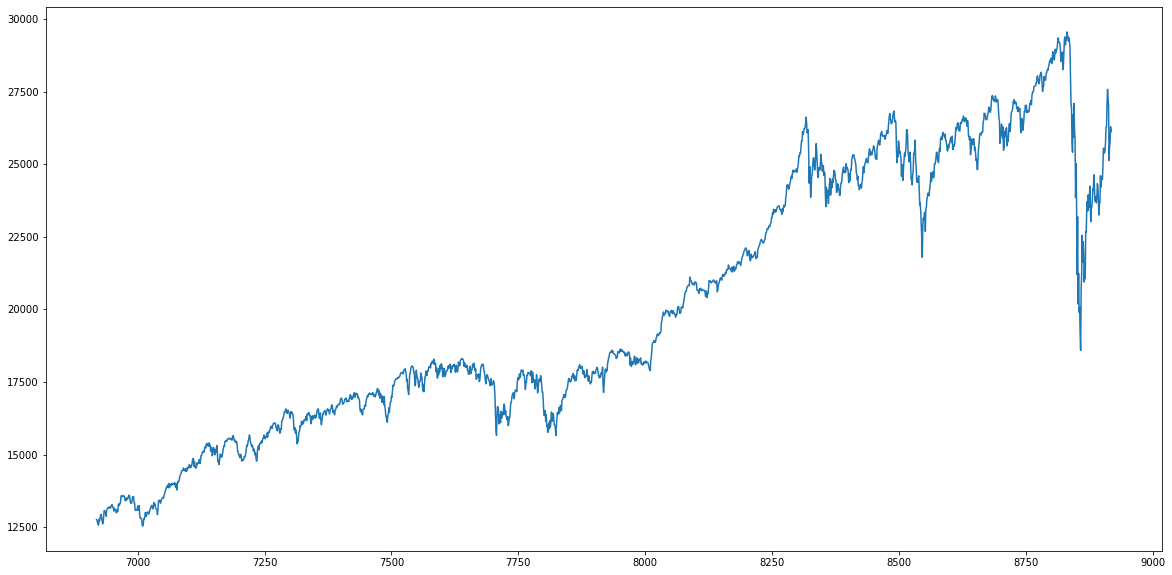

In [8]:
fig = plt.figure(figsize = (20, 10))
plt.plot(data['Close'])
plt.show()

In [9]:
points = data[['Open', 'High', 'Low', 'Close', 'Up', 'Down']].values.astype('float32')

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc_points = sc.fit_transform(points)

print(sc_points[0])

[-1.5685586  -1.5821836  -1.5969963  -1.5963866   0.15697235 -0.28730607]


In [16]:
close_point = data['Close'].values.reshape(-1, 1)/30000.0

In [17]:
points = np.concatenate([sc_points, close_point], axis = 1)

print(points[0])

[-1.56855857 -1.5821836  -1.59699631 -1.59638655  0.15697235 -0.28730607
  0.42574899]


In [18]:
split = len(points) - 60

print(split)

train_points = points[:split]
val_points = points[split:, :-1] 

print(train_points.shape, val_points.shape)

1940
(1940, 7) (60, 6)


![alt text](http://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2017/06/image2-e1496957521819.png)

In [19]:
#generate the sliding window datasets
#the latest 30 days are the input and the next day is output

window_size = 30
shuffle_buffer = 50
batch_size = 64

In [20]:
def windowed_dataset(series, window_size, shuffle_buffer, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size +1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window : window.batch(window_size +1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1, :-1], window[-1, -1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [21]:
dataset = windowed_dataset(points, window_size, shuffle_buffer, batch_size)

In [22]:
for x, y in dataset:
  print(x.shape, y.shape)

(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(64, 30, 6) (64,)
(50, 30, 6) (50,)


In [23]:
units = 128

model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters = 128, kernel_size = 11, activation = 'relu',
                                                           strides = 1, padding = 'causal', input_shape = [None, 6]),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences = True)),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),
                                    tf.keras.layers.Dense(1024, kernel_regularizer=regularizers.l2(0.1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.1)),
                                    tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Activation('relu'),
                                    tf.keras.layers.Dense(1)])

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mse', 'mae'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         8576      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         263168    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1

In [24]:

lr_reduce = ReduceLROnPlateau(monitor = 'loss',
                              min_lr = 0.0000001,
                              patience = 5,
                              verbose = 1,
                              factor = 0.1)

In [25]:
history = model.fit(dataset, 
                    epochs = 100, 
                    verbose = 1, 
                    callbacks = [lr_reduce])

Epoch 1/100
31/31 [==============================] - 11s 371ms/step - loss: 41.4367 - mse: 0.6972 - mae: 0.4732 - lr: 0.0010
Epoch 2/100
31/31 [==============================] - 9s 293ms/step - loss: 12.2825 - mse: 0.2015 - mae: 0.3282 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 9s 295ms/step - loss: 3.3899 - mse: 0.0797 - mae: 0.2184 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 9s 293ms/step - loss: 1.1769 - mse: 0.0802 - mae: 0.2097 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 9s 297ms/step - loss: 0.5545 - mse: 0.0546 - mae: 0.1803 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 9s 296ms/step - loss: 0.3432 - mse: 0.0416 - mae: 0.1619 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 9s 295ms/step - loss: 0.3113 - mse: 0.0830 - mae: 0.2109 - lr: 0.0010
Epoch 8/100
31/31 [==============================] - 9s 294ms/step - loss: 0.2760 - mse: 0.0444 - mae: 0.1438 - lr: 0.0010
Epoch 9/100
3

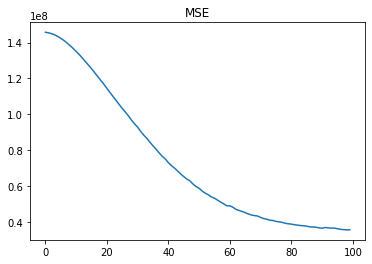

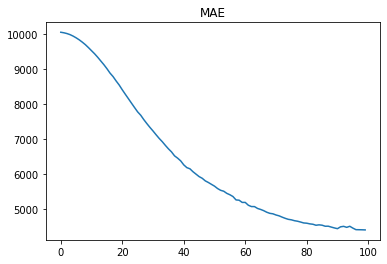

In [24]:

plt.plot(history.history['mse'])
plt.title('MSE')
plt.show()

plt.plot(history.history['mae'])
plt.title('MAE')
plt.show()

In [26]:
def forecast(model, series, window_size, batch_size):
  forecast = tf.data.Dataset.from_tensor_slices(series)
  forecast = forecast.window(window_size, shift = 1, drop_remainder = True)
  forecast = forecast.flat_map(lambda window: window.batch(window_size))
  forecast = forecast.batch(batch_size).prefetch(1)
  forecast = model.predict(forecast)
  return forecast



forecast = forecast(model, points[:, :-1], window_size, batch_size)
print(forecast.shape)
val_forecast = forecast[split-window_size: -1]

print(val_forecast.shape)

(8890, 1)
(60, 1)


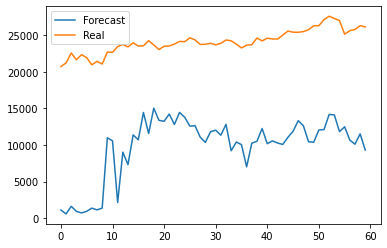

In [29]:
plt.plot(val_forecast, label = 'Forecast')
plt.plot(val_points[:,-1], label = 'Real')
plt.legend(loc = 'best')
plt.show()